<a href="https://colab.research.google.com/github/vijishmadhavan/Auto-Head-Swap/blob/master/Auto_headswap_single_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Inputs { display-mode: "form" }

import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import time
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Markdown, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2hsv, hsv2rgb
from cv2.ximgproc import guidedFilter
from PIL import ImageFilter
from PIL import Image, ImageEnhance

%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

!mkdir -p "/content/output"

def printmd(string):
    display(Markdown(string))

import cv2
import numpy as np
import urllib.request as urlreq
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
from google.colab.patches import cv2_imshow
%matplotlib inline

haarcascade_url = "1NXCKbuafQZekUstRytk1VO9fpjwujvJa"
haarcascade = "haarcascade_frontalface_alt2.xml"
!wget https://www.dropbox.com/s/0gg2t150j8kx285/haarcascade_frontalface_alt_tree.xml

if (haarcascade in os.listdir(os.curdir)):
  print("File exists")
else:
  !gdown --id $haarcascade_url --quiet
  print("File downloaded")
  
LBFmodel_url = "147T_RQSD7_EoT5TROMox8qrd-mFt6UqZ"
LBFmodel = "lbfmodel.yaml"

if (LBFmodel in os.listdir(os.curdir)):
    print("File exists")
else:
    !gdown --id $LBFmodel_url --quiet
    print("File downloaded")

def show_landmarks(landmarks, image):
  print(f"Detected {len(landmarks)} faces. ")
  img_show = cv2.imread(image)
  for landmark in landmarks:
    for i,(x,y) in enumerate(landmark[0]):

      #cv2.circle(img_show, (x,y),2,(255,255,255),2)
      img_show = cv2.putText(img_show, f"{i}", (int(x-5),int(y-5)), cv2.FONT_HERSHEY_SIMPLEX,  
                   0.5, (255, 0, 0) , 1, cv2.LINE_AA)

  cv2_imshow(img_show)

def landmarks(s_paths, show_lm=True):

  landmarks_arr = []
  detector = cv2.CascadeClassifier(haarcascade)

  landmark_detector = cv2.face.createFacemarkLBF()
  landmark_detector.loadModel(LBFmodel)

  for s_path in s_paths:
    image = cv2.imread(s_path)[...,::-1]
    image_landmarks = image.copy()
    image_draw = image.copy()
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    faces = detector.detectMultiScale(image_gray)
    
    _, landmarks = landmark_detector.fit(image_gray, faces)
    landmarks_arr.append(landmarks)
  
  if show_lm:
    for i, s_path in enumerate(s_paths):
      show_landmarks(landmarks_arr[i], s_path)

  return landmarks_arr

def landmarks_loaded(loaded_imgs, show_lm=True):
  landmarks_arr = []

  detector = cv2.CascadeClassifier(haarcascade)
  landmark_detector = cv2.face.createFacemarkLBF()
  landmark_detector.loadModel(LBFmodel)

  for ld_img in loaded_imgs:
    image = ld_img
    image_landmarks = image.copy()
    image_draw = image.copy()
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = detector.detectMultiScale(image_gray)
    _, landmarks = landmark_detector.fit(image_gray, faces)
    landmarks_arr.append(landmarks)

  return landmarks_arr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as modelzoo

resnet18_url = 'https://download.pytorch.org/models/resnet18-5c106cde.pth'


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_chan, out_chan,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
                )

    def forward(self, x):
        residual = self.conv1(x)
        residual = F.relu(self.bn1(residual))
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    layers = [BasicBlock(in_chan, out_chan, stride=stride)]
    for i in range(bnum-1):
        layers.append(BasicBlock(out_chan, out_chan, stride=1))
    return nn.Sequential(*layers)


class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)
        self.init_weight()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x) # 1/8
        feat16 = self.layer3(feat8) # 1/16
        feat32 = self.layer4(feat16) # 1/32
        return feat8, feat16, feat32

    def init_weight(self):
        state_dict = modelzoo.load_url(resnet18_url)
        self_state_dict = self.state_dict()
        for k, v in state_dict.items():
            if 'fc' in k: continue
            self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module,  nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.bn(x))
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
        self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.conv_out(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = nn.BatchNorm2d(out_chan)
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        self.resnet = Resnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]
        feat8, feat16, feat32 = self.resnet(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])
        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat8, feat16_up, feat32_up  # x8, x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.BatchNorm2d):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(BiSeNet, self).__init__()
        self.cp = ContextPath()
        self.ffm = FeatureFusionModule(256, 256)
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]
        feat_res8, feat_cp8, feat_cp16 = self.cp(x)  # here return res3b1 feature
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm(feat_sp, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
        feat_out16 = self.conv_out16(feat_cp8)
        feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)
        feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)
        feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)
        return feat_out, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, FeatureFusionModule) or isinstance(child, BiSeNetOutput):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params


bisenet_fn = "bisenet_pretrained.pth"
bisenet_url = "1X_oBCBkhSi2W3lA_sOd_5P_M0I00idnv"

if (bisenet_fn in os.listdir(os.curdir)):
  print("File exists")
else:
  !gdown --id $bisenet_url --quiet
  print("File downloaded")


import torch

import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2

pretrained_W = "/content/bisenet_pretrained.pth"

def face2parsing_maps(img_path):
  """
    Parsing of the img_path image
  """
  n_classes = 19
  net = BiSeNet(n_classes=n_classes)
  net.cpu()
  net.load_state_dict(torch.load(pretrained_W, map_location = torch.device('cpu')))
  net.eval()

  to_tensor = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  ])
  with torch.no_grad():
      img = Image.open(img_path)
      
      image = img.resize((512, 512), Image.BILINEAR)

      img = to_tensor(image)
      img = torch.unsqueeze(img, 0)
      img = img.cpu()
      out = net(img)[0]
      parsing = out.squeeze(0).cpu().numpy().argmax(0)

  return parsing
def parsing2mask(im, parsing_anno, include=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0,0,0]):
    """
      im is a cv2 image
      parsing_anno is the parsing returned by face2parsing_maps
    """
    points = [[],[]]
    vis_im = im.copy().astype(np.uint8)
    vis_parsing_anno = parsing_anno.copy().astype(np.uint8)
    num_of_class = np.max(vis_parsing_anno)
    mask = np.zeros((vis_parsing_anno.shape[0], vis_parsing_anno.shape[1], 1))
    
    for pi in range(1, num_of_class + 1):
        index = np.where(vis_parsing_anno == pi)

        points[0].append(index[0])
        points[1].append(index[1])

        mask[index[0], index[1], :] = include[pi]

    crop = vis_im.copy()
    
    mask_resized = cv2.resize(mask,(im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)
    bitws = cv2.bitwise_and(crop,crop,mask=np.uint8(mask_resized))

    return bitws, mask_resized, points



In [ ]:
#@title Install { display-mode: "form" }

!pip install -q git+https://github.com/wiktorlazarski/head-segmentation.git

In [11]:
#@title Crop { display-mode: "form" }

import cv2
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import pyplot as plt
from cv2.ximgproc import guidedFilter
from matplotlib import cm
from PIL import Image
import matplotlib.pyplot as plt1
import head_segmentation.segmentation_pipeline as seg_pipeline
import head_segmentation.visualization as vis



def cropface(image, box, fill=50):
  shape = image.shape
  if len(shape) > 2 :
    h,w,c = shape
  else:
    h,w = shape

    print(mask)

  x,y,w,h = box

  y_fill = y-(fill//2) if y-(fill//2) > 0 else 0
  x_fill = x-(fill//2) if x-(fill//2) > 0 else 0

  h_fill = y+h+fill 
  w_fill = x+w+fill

  return image[y_fill:(h_fill),(x_fill):(w_fill)]

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

segmentation_pipeline = seg_pipeline.HumanHeadSegmentationPipeline()

def segment(image):
  segmentation_map = segmentation_pipeline(image)

  return segmentation_map

def get_masked_blur(mask, FM, kernel_s, iteration=1):
  kernel = np.ones(kernel_s,np.uint8)

  mask_im = np.array([mask,mask,mask]).transpose((1,2,0))
  mask_im = cv2.erode(mask_im, kernel, iteration)  
  

  mask_im = (cv2.GaussianBlur(mask_im, (FM,FM), 0) > 0) * 1.0
  mask_im = cv2.GaussianBlur(mask_im, (FM,FM), 0)
  return mask_im  

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

def head(path):
  crop_p = "/content/head.jpg"
  parsing = face2parsing_maps(path)
  image = cv2.imread(path)

  masked, mask, points = parsing2mask(image, parsing)

  box = cv2.boundingRect(mask.astype(np.uint8))
  crop_img = cropface(image, box, fill=50)

  if crop_img.shape[1] > 1000:
    crop_r = image_resize(crop_img, width = 1000)
    print("Resizing Face")
  else:
    crop_r = crop_img
    
  plt.imsave(crop_p, crop_r[...,::-1])


def ref(path):
  #path = "'" + path +"'"
  cascPath = "/content/haarcascade_frontalface_alt2.xml"
  faceCascade = cv2.CascadeClassifier(cascPath)
  head(path)
  im = Image.open("/content/head.jpg")
  im.save("test.jpg")

  image_crop = im.convert('RGB')

  image = cv2.imread("/content/head.jpg")


  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=20,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE)
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (0, 0), (x+w+w, y+h+h+20), (0, 255, 0), 2)
  cropped_image = im.crop((0, 0, (x+w+w), (y+h+h+20)))

  cropped_image.save("rf_template.jpg")
  sample = cv2.imread("/content/rf_template.jpg")
  mask = cv2.imread("/content/rf_template.jpg")
  mask_face = segment(mask)
  i3 = (mask_face*255).astype(np.uint8)
  flags = cv2.INPAINT_TELEA
  output = cv2.inpaint(sample, i3, 55, flags=flags)
  output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
  Image2 = Image.fromarray(output)
  Image2.save("hl_template.jpg")
  Image1copy = image_crop.copy()
  Image2copy = Image2.copy()
  Image1copy.paste(Image2copy, (0,0))
  #Image1copy.save('nohead.jpg')



def source(path):
  crop_p = "/content/source.jpg"
  parsing = face2parsing_maps(path)
  image = cv2.imread(path)

  masked, mask, points = parsing2mask(image, parsing)

  box = cv2.boundingRect(mask.astype(np.uint8))
  crop_img = cropface(image, box, fill=50)

  if crop_img.shape[1] > 1000:
    crop_r = image_resize(crop_img, width = 1000)
    print("Resizing Face")
  else:
    crop_r = crop_img
    
  plt.imsave(crop_p, crop_r[...,::-1])



In [12]:

#headless template - Replace the head with source image Full body
ref("/content/er1.jpg")
#source image Full body
source("/content/54 (1).jpeg")


Resizing Face


Inputs
There is more components than expected
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Detected 2 faces. 


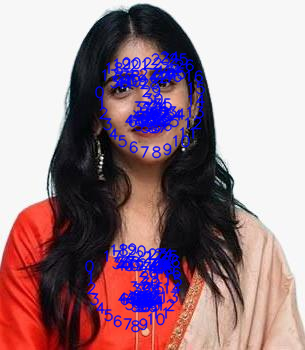

Detected 1 faces. 


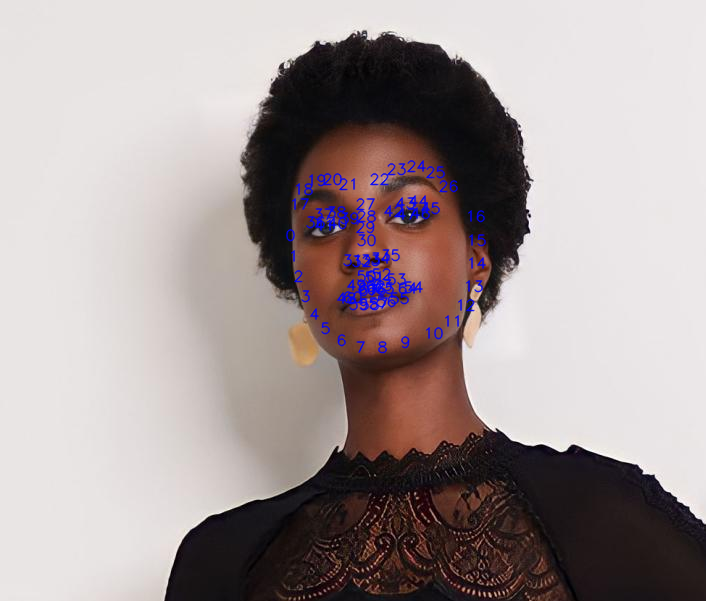

Swap Done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

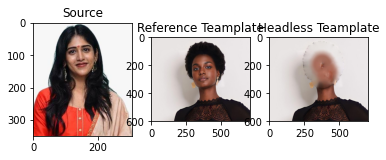

In [13]:
#@title Output { display-mode: "form" }

import gdown 
toggle_custom_name = True 
custom_source_name = "source.jpg" 

styles_arr = ['royal_1','royal_2','royal_3','royal_4','cather_5e6','choosing_crop','choosing5e5','courage_crop','Integrity_400','Integrity_crop','Integrity8e5','Interplay_m','Interplay','Justice_7e5','Lucian2','MeaningF_crop','MeaningF_crop2','MeaningF_m_488','MeaningF5e5','Mike_7e5','Miller_7e5','Miller_244','Miller_488','Mindseye5e5','Paul_7e5','Paul_crop_7e5','Tail_7e5','UdnieSS']
style_selector = "royal_1" 
style_id = styles_arr.index(style_selector) + 1


do_correction_filters = False 
double_color_match = False 
contrast_ = 0.2 
saturation_ = 0.05 
brightness_ = -0.05 


do_automatic_color = False 
auto_color_intensity_ = 5.1
color_variation_ = 10
color_var = color_variation_/1e6


do_hue_filter = False 
hue_shifter_ = 220.5 
hue_intensity_ = 12.6 


if toggle_custom_name:
  source_path = f"/content/{custom_source_name}"
else:
  source_path = "/content/source.jpg"


source_name = os.path.split(source_path)[-1]
refTemp_path = "/content/rf_template.jpg"
hless_path  = "/content/hl_template.jpg"


cropface_path = f"/content/output/crop_source.jpg"
cropfacestyle_path = "/content/output/cropface_style.jpg"
cropfacestyleCT_path ="/content/output/cropface_styleCT.jpg"


final_image_path = "/content/output/final_image.jpg"

source_im = cv2.imread(source_path)
refTemp_im = cv2.imread(refTemp_path)
hlessTemp_im = cv2.imread(hless_path)

plt.subplot(131)
plt.title('Source')
plt.imshow(source_im[...,::-1])

plt.subplot(132)
plt.title('Reference Teamplate')
plt.imshow(refTemp_im[...,::-1])

plt.subplot(133)
plt.title('Headless Teamplate')
plt.imshow(hlessTemp_im[...,::-1])

print('Inputs')




def draw_facebox(filename, dim, fill):
    x,y,w,h = dim
    data = plt.imread(filename)
    plt.imshow(data)
    ax = plt.gca()
    x, y, width, height = dim
    rect = plt.Rectangle((x-fill/2, y-fill/2,), width+fill, height+fill, fill=False, color='orange')
    ax.add_patch(rect)
    plt.show()

def cropface(image, box, fill=50):
  shape = image.shape
  if len(shape) > 2 :
    h,w,c = shape
  else:
    h,w = shape

    print(mask)

  x,y,w,h = box

  y_fill = y-(fill//2) if y-(fill//2) > 0 else 0
  x_fill = x-(fill//2) if x-(fill//2) > 0 else 0

  h_fill = y+h+fill 
  w_fill = x+w+fill

  return image[y_fill:(h_fill),(x_fill):(w_fill)]

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

parsing = face2parsing_maps(source_path)
masked, mask, points = parsing2mask(source_im, parsing)

box = cv2.boundingRect(mask.astype(np.uint8))
cropface_img = cropface(source_im, box, fill=50)

if cropface_img.shape[1] > 1000:
  crop_r = image_resize(cropface_img, width = 1000)
  print("Resizing Face")
else:
  crop_r = cropface_img
  
plt.imsave(cropface_path, crop_r[...,::-1])


crop_im = cv2.imread(cropface_path)

parsing_c = face2parsing_maps(cropface_path)
masked_c, mask_c, points = parsing2mask(crop_im, parsing_c)

nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(mask_c.astype(np.uint8), connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1

if nb_components > 2:
  min_size = 150  
  
  print("There is more components than expected")

!mkdir -p /content/styles
def get_id(argument):
    switcher = {
        1: "191u0U8owlL7ivJblZEjWHqQ5wl4UyuJA", # royal_1
        2: "1K2kVzhzM0Tcs2CW9_UYVkQu1YD7ZPPrw", # royal_2
        3: "11GzxCHRC2I_YinX2WnEdhOzGXU9HDxvX", # royal_3
        4: "1PftlIqtWEk99h8lzS7Z_5Mv1swojg0Tx",  # royal_4
        5: "1-JH6mVmJ8wAN6s3Avo-YAzP6SOcsW9la",  # cather_5e6
        6: "1-JH6mVmJ8wAN6s3Avo-YAzP6SOcsW9la",  # choosing_crop
        7: "1-cfb8oZuZFXGNYR6MOCyvt_v5avibB8h",  # choosing5e5
        8: "1-YLl5bDLC-sskj7zrK26l7vdXqyxSJNT",  # courage_crop
        9: "1-Qga7w08Lr6FWRxXagOFBha5cQymnqyy",  # Integrity_400
        10: "113Um7No7tiudsrbc-o-J15B3plHN8TYc",  # Integrity_crop
        11: "1-xnVWwx-KB501l-Co7o_07Vckhs7cqP8",  # Integrity8e5
        12: "12i_3sVtmh68fMkFrLU3w3gyJYK2cZKlZ",  # Interplay_m
        13: "10EFnY78K8AhW_UbSKZOz7MiMq0V15jJZ",  # Interplay
        14: "1-U3TVDMn7SAJSaOsX8pT9YtAz3e9zOPq",  # Justice_7e5
        15: "10SZLmTfskEwFnkKwFoTrUe5ljaxWjoOL",  # Lucian2
        16: "1-zSLHxt8jbSByzHYU5Dxr6ntyY2_ppz7",  # MeaningF_crop
        17: "12PXnOR5leAHaIf2choD9LUaQhG71QvMs",  # MeaningF_crop2
        18: "10vg1ykCBXH_8XkMypWHRXRnqNUEX8sCw",  # MeaningF_m_488
        19: "10Ni8oE7_BpPBjlGL-See--j9_R5aC2CU",  # MeaningF5e5
        20: "11I2apRrHfKaDmJVR7KE_9PBN_PT7mMSt",  # Mike_7e5
        21: "10TJfZYiWamRNRrzQvW7CO5eCpP_R1FVA",  # Miller_7e5
        22: "1-ys3xyupkf9s2Fw8-0IC_X-9MsVm0HUG",  # Miller_244
        23: "10-qdjq5x5Z3CY1PvqNIq_246WJofZCMF",  # Miller_488
        24: "1-XwqLcJYWUMEChwBCv11wH1tbdKMsMsi",  # Mindseye5e5
        25: "11Ks6rsS1rsNLQ4eg8_TeR6QDHIrPe2nj",  # Paul_7e5
        26: "10Ba4vn4Md_ukC651td-POu5AFqaIm8lG",  # Paul_crop_7e5
        27: "10mO5e_OvWlTOfBDVRyYTZogG-rkOJmxN",  # Tail_7e5
        28: "12AZRFv6XtI3gzACSlEwBTDPXoIHNuvHn"  # UdnieSS
    }

    return switcher.get(argument, "Invalid Style")
gd_id = get_id(style_id)
!gdown --id  $gd_id --quiet
#!gdown --id  $gd_id -O '/content/styles/$gd_id' --quiet

import torch
from torchvision import transforms
import re
from PIL import Image



def load_image(filename, size=None, scale=None):
    img = Image.open(filename)
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

def process_image(data):
    img = data.clone().clamp(0, 255).numpy()
    img_arr = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img_arr)
    return img, img_arr
    # img.save(filename)
# ----- Transformer Network
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()
        self.tan = torch.nn.Tanh()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)

        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out
model_path = f"/content/styles/{gd_id}"


device = torch.device("cpu")

content_image = load_image(cropface_path)
original_image = content_image

content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
])
content_image = content_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)


with torch.no_grad():
    style_model = TransformerNet()
    state_dict = torch.load("/content/st_style_1.pth")
    
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)

    output = style_model(content_image).cpu()

source_st, source_st_arr = process_image(output[0])

source_st = source_st.filter(ImageFilter.DETAIL)
source_st = source_st.filter(ImageFilter.SMOOTH_MORE)

# Saving the file
# source_st.save(cropfacestyle_path)
original_image.save(cropfacestyle_path)

import skimage 
import numpy as np
import imageio
from skimage import io,transform,img_as_float
from skimage.io import imread,imsave
from PIL import Image
from numpy import eye 

def match_color(target_img, source_img, eps=1e-5):

    mu_t = target_img.mean(0).mean(0)
    t = target_img - mu_t
    t = t.transpose(2,0,1).reshape(3,-1)
    Ct = t.dot(t.T) / t.shape[1] + eps * np.eye(t.shape[0])
    mu_s = source_img.mean(0).mean(0)
    s = source_img - mu_s
    s = s.transpose(2,0,1).reshape(3,-1)
    Cs = s.dot(s.T) / s.shape[1] + eps * np.eye(s.shape[0])

    #PCA mode
    eva_t, eve_t = np.linalg.eigh(Ct)
    Qt = eve_t.dot(np.sqrt(np.diag(eva_t))).dot(eve_t.T)
    eva_s, eve_s = np.linalg.eigh(Cs)
    Qs = eve_s.dot(np.sqrt(np.diag(eva_s))).dot(eve_s.T)
    ts = Qs.dot(np.linalg.inv(Qt)).dot(t)


    matched_img = ts.reshape(*target_img.transpose(2,0,1).shape).transpose(1,2,0)
    matched_img += mu_s
    matched_img[matched_img>1] = 1
    matched_img[matched_img<0] = 0
    
    return matched_img	

import skimage 
import numpy as np
import imageio
from skimage import io,transform,img_as_float
from skimage.io import imread,imsave
from PIL import Image
from numpy import eye 
import cv2
from google.colab.patches import cv2_imshow

def rgb2luv(image):
    img = image.transpose(2,0,1).reshape(3,-1)
    luv = np.array([[.299, .587, .114],[-.147, -.288, .436],[.615, -.515, -.1]]).dot(img).reshape((3,image.shape[0],image.shape[1]))
    return luv.transpose(1,2,0)
def luv2rgb(image):
    img = image.transpose(2,0,1).reshape(3,-1)
    rgb = np.array([[1, 0, 1.139],[1, -.395, -.580],[1, 2.03, 0]]).dot(img).reshape((3,image.shape[0],image.shape[1]))
    return rgb.transpose(1,2,0)

def doColorTransfer(org_content, output, with_color_match = False):
  
  org_content = imageio.imread(org_content, pilmode="RGB").astype(float)/256 # original img
  output = imageio.imread(output, pilmode="RGB").astype(float)/256 # outputst


  if with_color_match:
    output = match_color(output, org_content)
  
  org_content = skimage.transform.resize(org_content, output.shape)

  org_content = rgb2luv(org_content)
  org_content[:,:,0] = output.mean(2)
  output = luv2rgb(org_content)
  output[output<0] = 0
  output[output>1]=1

  return output

def doColorTransfer_(org_content, output, output_f = "/content/"):

  org_content = org_content[...,::-1].astype(float)/256
  output = output[...,::-1].astype(float)/256

  org_content = cv2.resize(org_content, output.shape[:2])

  org_content = rgb2luv(org_content)
  org_content[:,:,0] = output.mean(2)
  output = luv2rgb(org_content)
  output[output<0] = 0
  output[output>1]=1

  return output

cropface_styleCT = doColorTransfer(cropface_path, cropfacestyle_path, with_color_match = double_color_match)

# Filters
cropf_ct = Image.fromarray((cropface_styleCT * 255).astype(np.uint8))
if do_correction_filters:
  contrast_enh = ImageEnhance.Contrast(cropf_ct)
  contrast_filter = contrast_enh.enhance(1.0 + contrast_)

  color_enh = ImageEnhance.Color(contrast_filter)
  color_filter = color_enh.enhance(1.0+saturation_)

  br_enh = ImageEnhance.Brightness(color_filter)
  br_filter = br_enh.enhance(1.0 +brightness_)

  br_filter.save(cropfacestyleCT_path)

else:
  cropf_ct.save(cropfacestyleCT_path)

def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                      c2.T - (s2 / s1) * R * c1.T)),
                        np.matrix([0., 0., 1.])])
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                  M[:2],
                  (dshape[1], dshape[0]),
                  dst=output_im,
                  borderMode=cv2.BORDER_TRANSPARENT,
                  flags=cv2.WARP_INVERSE_MAP)
    return output_im

# Blurring the mask and converting it to 3 channel binary mask
def get_masked_blur(mask, FM, kernel_s, iteration=1):
  kernel = np.ones(kernel_s,np.uint8)

  mask_im = np.array([mask,mask,mask]).transpose((1,2,0))
  mask_im = cv2.erode(mask_im, kernel, iteration)  
  

  mask_im = (cv2.GaussianBlur(mask_im, (FM,FM), 0) > 0) * 1.0
  mask_im = cv2.GaussianBlur(mask_im, (FM,FM), 0)
  return mask_im  

def correct_colours(im1, im2, landmarks1, COLOUR_CORRECT_BLUR_FRAC,points):
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[points[0]], axis=0) -
                              np.mean(landmarks1[points[1]], axis=0))
    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += 128 * (im2_blur <= 1.0).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))

def doTheSwap(source_path, 
              style_path, ref_path, 
              headless_path, 
              hue_value=260, 
              alpha_blend=40, 
              alpha_blend_color=40,
              color_variation=1e-5, 
              hue_change=False, 
              morph_closing=False,
              linear_color=False):

  eps = 5e-6
  eps *= 255*255
  COLOUR_CORRECT_BLUR_FRAC = 0.6
  LEFT_EYE_POINTS = list(range(42, 48))
  RIGHT_EYE_POINTS = list(range(36, 42))
  FACE_POINTS = list(range(17, 68))
  LEFT_EYE_POINTS = list(range(42, 48))
  RIGHT_EYE_POINTS = list(range(36, 42))
  LEFT_BROW_POINTS = list(range(22, 27))
  RIGHT_BROW_POINTS = list(range(17, 22))
  NOSE_POINTS = list(range(27, 35))
  MOUTH_POINTS = list(range(48, 61))
  JAW_POINTS_ = list(range(4, 13))
  ALIGN_POINTS = (JAW_POINTS_)

  OVERLAY_POINTS = [
      LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS+
      NOSE_POINTS + MOUTH_POINTS+JAW_POINTS_
  ]

  FEATHER_AMOUNT = 15 

  # Landmarks
  lm = landmarks([source_path, ref_path], True)
  source_lm = lm[0][0][0]
  target_lm = lm[1][0][0]

  # Getting the transformation matrix
  tr = transformation_from_points(np.matrix(target_lm), np.matrix(source_lm))

  # Reading inputs and showing { form-width: "33%" }
  source_im = cv2.imread(source_path, cv2.IMREAD_COLOR)
  style_im = cv2.imread(style_path, cv2.IMREAD_COLOR)
  target_im = cv2.imread(ref_path, cv2.IMREAD_COLOR)
  head_less = cv2.imread(headless_path, cv2.IMREAD_COLOR)

  style_linear_ct = match_color(style_im[...,::-1]/255, head_less[...,::-1]/255, eps = color_variation)

  if linear_color:
    style_im = cv2.addWeighted(style_im, alpha_blend_color/100, (style_linear_ct*255).astype(np.uint8), (1-alpha_blend_color/100),0, dtype=cv2.CV_8U)
    style_im = style_im[...,::-1]


  # Face segmentantion & mask of source
  parsing = face2parsing_maps(source_path)
  masked_face, mask_face, points_face = parsing2mask(source_im, parsing, include=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0,0,0]) 
  
  mask_face = guidedFilter(source_im.astype(np.float32), mask_face.astype(np.float32), 10, eps)
  mask_face3d = np.array([mask_face,mask_face,mask_face]).transpose(1,2,0)

  #print('face mask')
  #cv2_imshow(mask_face*255)
  #cv2_imshow(masked_face)

  
  ## mask_face3d = get_masked_blur(mask_face, 15, (15,15)) #<- blurs and makes 3d mask
  # masked_hair, mask_hair, points_hair = parsing2mask(source_im, parsing, include=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0])  

  

  # Hair mask process
  # mask_hair_erode = cv2.erode(mask_hair, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations = 3)
  # better_hair = guidedFilter(source_im.astype(np.float32), mask_hair_erode.astype(np.float32), 10, eps)
  # better_hair3d = np.array([better_hair,better_hair,better_hair]).transpose(1,2,0)

  # mask_blur = get_masked_blur(mask, 15, (15,15)) 


  # compose_mask =  better_hair3d + mask_face3d
  compose_mask =  mask_face3d

  # Mask morph operations
  if morph_closing:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10, 10))
    compose_mask = cv2.morphologyEx(compose_mask, cv2.MORPH_CLOSE, kernel)
    compose_mask = cv2.morphologyEx(compose_mask, cv2.MORPH_OPEN, kernel)

  s_lm = np.matrix(source_lm[ALIGN_POINTS])
  t_lm = np.matrix(target_lm[ALIGN_POINTS])
  M = transformation_from_points(t_lm, s_lm) 

  
  warped_mask = warp_im(compose_mask, M, target_im.shape)
  #print('warped_mask')
  #cv2_imshow(warped_mask*255)

  # Warped style/source image
  if hue_change:
    # hue filter
    hsv_img = rgb2hsv(style_im/255)
    rgb_img = hsv2rgb(hsv_img)

    hue_mean = np.mean(hsv_img[:,:,0])*360

    picked_hue = 260
    if hue_mean < picked_hue:
      hue_shifter = (picked_hue-hue_mean)/360
    else:
      hue_shifter = (hue_mean-picked_hue)/360
      hue_shifter = -hue_shifter
    
    new_hue = np.array([hsv_img[:,:,0]+hue_shifter, hsv_img[:,:,1], hsv_img[:,:,2]]).transpose(1,2,0)
    
    new_img = hsv2rgb(new_hue)
    
    blend_hue = cv2.addWeighted(new_img, alpha_blend/100,rgb_img, (1-alpha_blend/100),0)

    warped_source_im = warp_im(blend_hue*255, M, target_im.shape)
  else:
    warped_source_im = warp_im(style_im, M, target_im.shape)
    #print('warped_source_im')
    #cv2_imshow(warped_source_im)



  final = head_less*(1-warped_mask)+(warped_source_im*warped_mask)

  
  
  print("Swap Done")
  return final


SwapDone = doTheSwap(cropface_path, 
                    cropfacestyleCT_path, 
                    refTemp_path, 
                    hless_path, 
                    alpha_blend = hue_intensity_, 
                    alpha_blend_color=auto_color_intensity_,
                    hue_value=hue_shifter_, 
                    hue_change=do_hue_filter,
                    #  hue_change=False,
                    color_variation=color_var,
                    linear_color=do_automatic_color,
                    morph_closing=False)


cv2.imwrite(final_image_path, SwapDone)
Image2 = Image.open("/content/output/final_image.jpg")
#deeplab_model = load_model()
#foreground, bin_mask = remove_background(deeplab_model, '/content/output/final_image.jpg')
#final_image = custom_background('/content/wb.jpg', foreground)
#final_image.save("/content/final.jpg")
#Image2 = Image.open("/content/final.jpg")

image = cv2.imread("/content/test.jpg")
image_crop = Image.open("/content/test.jpg")
image_crop = image_crop.convert('RGB')


Image2copy = Image2.copy()
Image1copy = image_crop.copy()
cascPath = "/content/haarcascade_frontalface_alt2.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
final_image_p = "/content/output/final_img.jpg"
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = faceCascade.detectMultiScale(gray,
  scaleFactor=1.1,
  minNeighbors=20,
  minSize=(30, 30),
  flags = cv2.CASCADE_SCALE_IMAGE)
for (x, y, w, h) in faces:
  cv2.rectangle(image, (0, 0), (x+w+w, y+h+h+20), (0, 255, 0), 2)

#Image2copy = Image2.copy()
#Image1copy = image_crop.copy()
Image1copy.paste(Image2copy, (0, 0))
Image1copy.save(final_image_p)
time.sleep(0.5)
files.download(final_image_p)